In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import collections
from tqdm import tqdm
sns.set()

In [2]:
def build_dataset(words, n_words, atleast=1):
    count = [['PAD', 0], ['GO', 1], ['EOS', 2], ['UNK', 3]]
    counter = collections.Counter(words).most_common(n_words)
    counter = [i for i in counter if i[1] >= atleast]
    count.extend(counter)
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

In [3]:
with open('shakespeare.txt') as fopen:
    shakespeare = fopen.read().split()

In [4]:
vocabulary_size = len(list(set(shakespeare)))
data, count, dictionary, rev_dictionary = build_dataset(shakespeare, vocabulary_size)

In [5]:
GO = dictionary['GO']
PAD = dictionary['PAD']
EOS = dictionary['EOS']
UNK = dictionary['UNK']

In [6]:
class Generator:
    def __init__(self, size_layer, num_layers, embedded_size,
                 from_dict_size, to_dict_size, learning_rate, batch_size):
        
        def cells(reuse=False):
            return tf.nn.rnn_cell.GRUCell(size_layer,reuse=reuse)
        
        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.int32, [None, None])
        self.X_seq_len = tf.count_nonzero(self.X, 1, dtype=tf.int32)
        self.Y_seq_len = tf.count_nonzero(self.Y, 1, dtype=tf.int32)
        batch_size = tf.shape(self.X)[0]
        
        encoder_embedding = tf.Variable(tf.random_uniform([from_dict_size, embedded_size], -1, 1))
        decoder_embedding = tf.Variable(tf.random_uniform([to_dict_size, embedded_size], -1, 1))
        
        self.cells = tf.nn.rnn_cell.MultiRNNCell([cells() for _ in range(num_layers)])
        self.encoder_state = self.cells.zero_state(
            dtype = tf.float32, batch_size = tf.shape(self.X)[0]
        )
        
        _, encoder_state = tf.nn.dynamic_rnn(
            cell = self.cells, 
            inputs = tf.nn.embedding_lookup(encoder_embedding, self.X),
            sequence_length = self.X_seq_len,
            initial_state = self.encoder_state,
            dtype = tf.float32)
        
        main = tf.strided_slice(self.Y, [0, 0], [batch_size, -1], [1, 1])
        decoder_input = tf.concat([tf.fill([batch_size, 1], GO), main], 1)
        dense = tf.layers.Dense(to_dict_size)
        decoder_cells = tf.nn.rnn_cell.MultiRNNCell([cells() for _ in range(num_layers)])
        
        training_helper = tf.contrib.seq2seq.TrainingHelper(
                inputs = tf.nn.embedding_lookup(decoder_embedding, decoder_input),
                sequence_length = self.Y_seq_len,
                time_major = False)
        training_decoder = tf.contrib.seq2seq.BasicDecoder(
                cell = decoder_cells,
                helper = training_helper,
                initial_state = encoder_state,
                output_layer = dense)
        training_decoder_output, self.training_state, _ = tf.contrib.seq2seq.dynamic_decode(
                decoder = training_decoder,
                impute_finished = True,
                maximum_iterations = tf.reduce_max(self.Y_seq_len))
        self.training_logits = training_decoder_output.rnn_output
        
        predicting_decoder = tf.contrib.seq2seq.BeamSearchDecoder(
                cell = decoder_cells,
                embedding = decoder_embedding,
                start_tokens = tf.tile(tf.constant([GO], dtype=tf.int32), [batch_size]),
                end_token = EOS,
                initial_state = tf.contrib.seq2seq.tile_batch(self.encoder_state, 15),
                beam_width = 15,
                output_layer = dense,
                length_penalty_weight = 0.0)
        predicting_decoder_output, self.predict_state, _ = tf.contrib.seq2seq.dynamic_decode(
                decoder = predicting_decoder,
                impute_finished = False,
                maximum_iterations = tf.reduce_max(self.X_seq_len))
        
        self.predicting_ids = predicting_decoder_output.predicted_ids[:,:,0]
        
        masks = tf.sequence_mask(self.Y_seq_len, tf.reduce_max(self.Y_seq_len), dtype=tf.float32)
        self.cost = tf.contrib.seq2seq.sequence_loss(logits = self.training_logits,
                                                     targets = self.Y,
                                                     weights = masks)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
        y_t = tf.argmax(self.training_logits,axis=2)
        y_t = tf.cast(y_t, tf.int32)
        self.prediction = tf.boolean_mask(y_t, masks)
        mask_label = tf.boolean_mask(self.Y, masks)
        correct_pred = tf.equal(self.prediction, mask_label)
        correct_index = tf.cast(correct_pred, tf.float32)
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [8]:
learning_rate = 0.001
batch_size = 32
sequence_length = 64
epoch = 3000
num_layers = 2
size_layer = 256
possible_batch_id = range(len(data) - sequence_length - 1)

In [9]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Generator(size_layer, num_layers, size_layer, len(dictionary), 
                len(dictionary), learning_rate,batch_size)
sess.run(tf.global_variables_initializer())

In [10]:
def train_random_batch():
    LOST, ACCURACY = [], []
    pbar = tqdm(range(epoch), desc = 'epoch')
    batch_x = np.zeros((batch_size, sequence_length))
    batch_y = np.zeros((batch_size, sequence_length + 1))
    for n in range(batch_size):
        index = np.random.randint(0, len(data) - sequence_length - 1)
        batch_x[n] = data[index:index + sequence_length]
        batch_y[n] = data[index + 1:index + sequence_length + 1] + [EOS]
    initial_state, _ = sess.run([model.predict_state, model.optimizer], feed_dict = {model.X: batch_x,
                                                                                    model.Y: batch_y})
    initial_state = initial_state.cell_state
    initial_state = (initial_state[0][:,-1,:], initial_state[1][:,-1,:])
    
    for i in pbar:
        batch_x = np.zeros((batch_size, sequence_length))
        batch_y = np.zeros((batch_size, sequence_length + 1))
        for n in range(batch_size):
            index = np.random.randint(0, len(data) - sequence_length - 1)
            batch_x[n] = data[index:index + sequence_length]
            batch_y[n] = data[index + 1:index + sequence_length + 1] + [EOS]
        accuracy, _, loss, initial_state = sess.run([model.accuracy, model.optimizer, 
                                                     model.cost, model.predict_state], 
                                       feed_dict = {model.X: batch_x, 
                                                    model.Y: batch_y,
                                                    model.encoder_state: initial_state})
        initial_state = initial_state.cell_state
        initial_state = (initial_state[0][:,-1,:], initial_state[1][:,-1,:])
        ACCURACY.append(accuracy); LOST.append(loss)
        pbar.set_postfix(cost = loss, accuracy = accuracy)
    return LOST, ACCURACY

In [11]:
LOST, ACCURACY = train_random_batch()

epoch: 100%|██████████| 3000/3000 [27:14<00:00,  2.08it/s, accuracy=0.348, cost=3.35]  


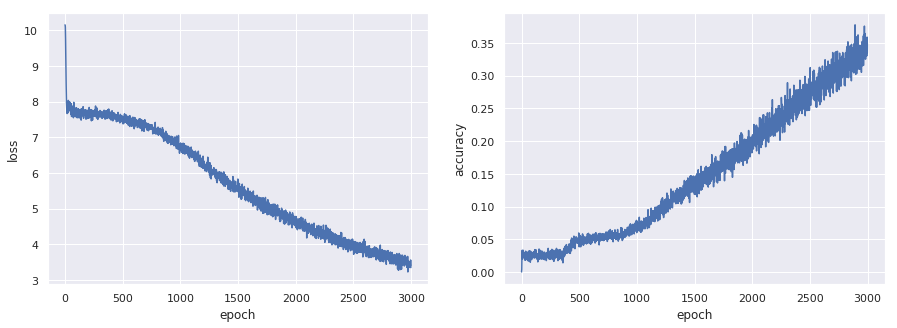

In [13]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
EPOCH = np.arange(len(LOST))
plt.plot(EPOCH, LOST)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, ACCURACY)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [22]:
def generate_based_sequence(length_sentence):
    index = np.random.randint(0, len(data) - sequence_length - 1)
    x = np.array([data[index:index + sequence_length]])
    initial_state, ids = sess.run([model.predict_state,model.predicting_ids], 
                                  feed_dict = {model.X: x})
    initial_state = initial_state.cell_state
    initial_state = (initial_state[0][:,-1,:], initial_state[1][:,-1,:])
    ids = ids[0].tolist()

    while len(ids) < length_sentence:
        initial_state, ids_ = sess.run([model.predict_state,model.predicting_ids], 
                                      feed_dict = {model.X: [ids[-sequence_length:]],
                                                  model.encoder_state: initial_state})
        ids.extend(ids_[0].tolist())
        initial_state = initial_state.cell_state
        initial_state = (initial_state[0][:,-1,:], initial_state[1][:,-1,:])

    return ' '.join([rev_dictionary[i] for i in ids])

In [23]:
print(generate_based_sequence(1000))

EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS 